# Evaluate the adapter fine-tuned on `mpnet` model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
from llama_index.embeddings.adapter.utils import TwoLayerNN
from llama_index.embeddings.adapter import AdapterEmbeddingModel
from llama_index.core.embeddings import resolve_embed_model
import time
from IPython.display import clear_output

In [2]:
model_name = "sentence-transformers/paraphrase-mpnet-base-v2"
base_embed_model = resolve_embed_model(f"local:{model_name}")

In [ ]:
embed_model = AdapterEmbeddingModel(
    base_embed_model,
    "mpnet_finetuned_ep8",
    TwoLayerNN,
    device="cuda"
)

/export/home/co21btech11001/.conda/envs/nlp_env/lib/python3.10/site-packages/llama_index/embeddings/adapter/utils.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.

In [4]:
df_ques_url_train = pd.read_pickle('../../data/questions_relevant_urls_chunks_train.pkl')
df_ques_url_test = pd.read_pickle('../../data/questions_relevant_urls_chunks_test.pkl')

print(df_ques_url_train.shape)
print(df_ques_url_test.shape)
df_ques_url_train.head(3)

(20000, 3)
(5000, 3)


,question,relevant_docs_urls,num_rel_chunks
0,What is (are) keratoderma with woolly hair ?,[https://ghr.nlm.nih.gov/condition/keratoderma...,5
1,How many people are affected by keratoderma wi...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5
2,What are the genetic changes related to kerato...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5


In [5]:
df_kb = pd.read_pickle('../../data/kb_chunks_emb_finetuned.pkl')
print(df_kb.shape)
df_kb.head(3)

(33545, 3)


,doc_url,chunk_content,embedding
0,https://ghr.nlm.nih.gov/condition/keratoderma-...,keratoderma with woolly hair : medlineplus gen...,"[-0.0015540259191766381, 0.031236015260219574,..."
1,https://ghr.nlm.nih.gov/condition/keratoderma-...,"##ma, woolly hair, and a form of cardiomyopath...","[-0.03523554652929306, -0.03372985124588013, 0..."
2,https://ghr.nlm.nih.gov/condition/keratoderma-...,##pathy in people with this group of condition...,"[0.009989160113036633, 0.02316436544060707, 0...."


In [6]:
# from tqdm import tqdm
# tqdm.pandas()

In [7]:
df_kb['embedding'] = df_kb['chunk_content'].apply(
    lambda x: np.array(embed_model.get_text_embedding(x))
)

In [8]:
df_kb.to_pickle('../../data/kb_chunks_emb_finetuned_ep8.pkl')

In [9]:
def cos_sim(a, b):
    return 1 - spatial.distance.cosine(a, b)

def retrieve(ques, df_kb, model):
    question_embedding = np.array(model.get_query_embedding(ques))
    # Copy the 'doc_url' and 'embedding' columns to a new dataframe
    df_kb_copy = df_kb[['doc_url', 'embedding']].copy()
     # Calculate the cosine similarity between the question embedding and all document embeddings
    df_kb_copy['cosine_similarity'] = df_kb_copy['embedding'].apply(
        lambda x: cos_sim(question_embedding, x))
    # Sort the dataframe by the cosine similarity in descending order
    df_kb_copy = df_kb_copy.sort_values(by='cosine_similarity', ascending=False)
    ret_urls = df_kb_copy['doc_url'].values
    return ret_urls

def recall_at_k(num_rel_chunks, relevant_docs_urls, top_retrieved_urls):
    """
    Procedure:
    - Among top_retrieved_urls, count the number of urls which are relevant
    - Divide this count by the total number of relevant urls
    """
    num_relevant = 0
    for url in top_retrieved_urls:
        if url in relevant_docs_urls:
            num_relevant += 1
    return num_relevant / num_rel_chunks

def mrr_at_k(relevant_docs_urls, top_retrieved_urls):
    """
    Procedure:
    - For each relevant_docs_urls, find the top index in top_retrieved_urls
    - Take the reciprocal of this index
    - Return the mean of these reciprocals
    """
    li = []
    for url in relevant_docs_urls:
        if url in top_retrieved_urls:
            # list.index returns the first occurrence of the url
            li.append(1 / (list(top_retrieved_urls).index(url) + 1))
    if len(li) == 0:
        return 0
    return np.mean(li)

In [10]:
def evaluate(df_ques_url):
    recall_1_li = []; mrr_1_li = []
    recall_3_li = []; mrr_3_li = []
    recall_10_li = []; mrr_10_li = []
    recall_100_li = []; mrr_100_li = []

    start_time = time.time()
    complete = 0
    total = len(df_ques_url)
    for _, row in df_ques_url.iterrows():
        ques = row['question']
        relevant_urls = row['relevant_docs_urls']
        num_rel_chunks = row['num_rel_chunks']

        retrieved_urls = retrieve(ques, df_kb, embed_model)

        temp_recall_1 = recall_at_k(num_rel_chunks, relevant_urls, retrieved_urls[:1])
        temp_mrr_1 = mrr_at_k(relevant_urls, retrieved_urls[:1])
        temp_recall_3 = recall_at_k(num_rel_chunks, relevant_urls, retrieved_urls[:3])
        temp_mrr_3 = mrr_at_k(relevant_urls, retrieved_urls[:3])
        temp_recall_10 = recall_at_k(num_rel_chunks, relevant_urls, retrieved_urls[:10])
        temp_mrr_10 = mrr_at_k(relevant_urls, retrieved_urls[:10])
        temp_recall_100 = recall_at_k(num_rel_chunks, relevant_urls, retrieved_urls[:100])
        temp_mrr_100 = mrr_at_k(relevant_urls, retrieved_urls[:100])

        recall_1_li.append(temp_recall_1); mrr_1_li.append(temp_mrr_1)
        recall_3_li.append(temp_recall_3); mrr_3_li.append(temp_mrr_3)
        recall_10_li.append(temp_recall_10); mrr_10_li.append(temp_mrr_10)
        recall_100_li.append(temp_recall_100); mrr_100_li.append(temp_mrr_100)

        complete += 1
        percent_comp = (complete/total)*100
        clear_output(wait=True)
        print(f"Completed: {complete}/{total}: ({percent_comp:.2f}%)")

    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken: {time_taken:.2f} seconds")

    return recall_1_li, mrr_1_li, recall_3_li, mrr_3_li, recall_10_li, mrr_10_li, recall_100_li, mrr_100_li

def print_plot_results(df_ques_url):
    recall_1, mrr_1, recall_3, mrr_3, \
    recall_10, mrr_10, recall_100, mrr_100 = evaluate(df_ques_url)

    recall_1_score = np.mean(recall_1); mrr_1_score = np.mean(mrr_1)
    recall_3_score = np.mean(recall_3); mrr_3_score = np.mean(mrr_3)
    recall_10_score = np.mean(recall_10); mrr_10_score = np.mean(mrr_10)
    recall_100_score = np.mean(recall_100); mrr_100_score = np.mean(mrr_100)

    print(f"Recall@1: {recall_1_score:.4f}")
    print(f"Recall@3: {recall_3_score:.4f}")
    print(f"Recall@10: {recall_10_score:.4f}")
    print(f"Recall@100: {recall_100_score:.4f}")
    print()
    print(f"MRR@1: {mrr_1_score:.4f}")
    print(f"MRR@3: {mrr_3_score:.4f}")
    print(f"MRR@10: {mrr_10_score:.4f}")
    print(f"MRR@100: {mrr_100_score:.4f}")

    # Plot recall scores on histograms
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0, 0].hist(recall_1, bins=10, color='r', alpha=0.7)
    ax[0, 0].set_title('Recall@1')
    ax[0, 1].hist(recall_3, bins=10, color='g', alpha=0.7)
    ax[0, 1].set_title('Recall@3')
    ax[1, 0].hist(recall_10, bins=10, color='b', alpha=0.7)
    ax[1, 0].set_title('Recall@10')
    ax[1, 1].hist(recall_100, bins=10, color='y', alpha=0.7)
    ax[1, 1].set_title('Recall@100')
    plt.show()

Completed: 20000/20000: (100.00%)
Time taken: 4886.29 seconds
Recall@1: 0.1967
Recall@3: 0.3817
Recall@10: 0.5403
Recall@100: 0.6920

MRR@1: 0.7950
MRR@3: 0.8512
MRR@10: 0.8590
MRR@100: 0.8593


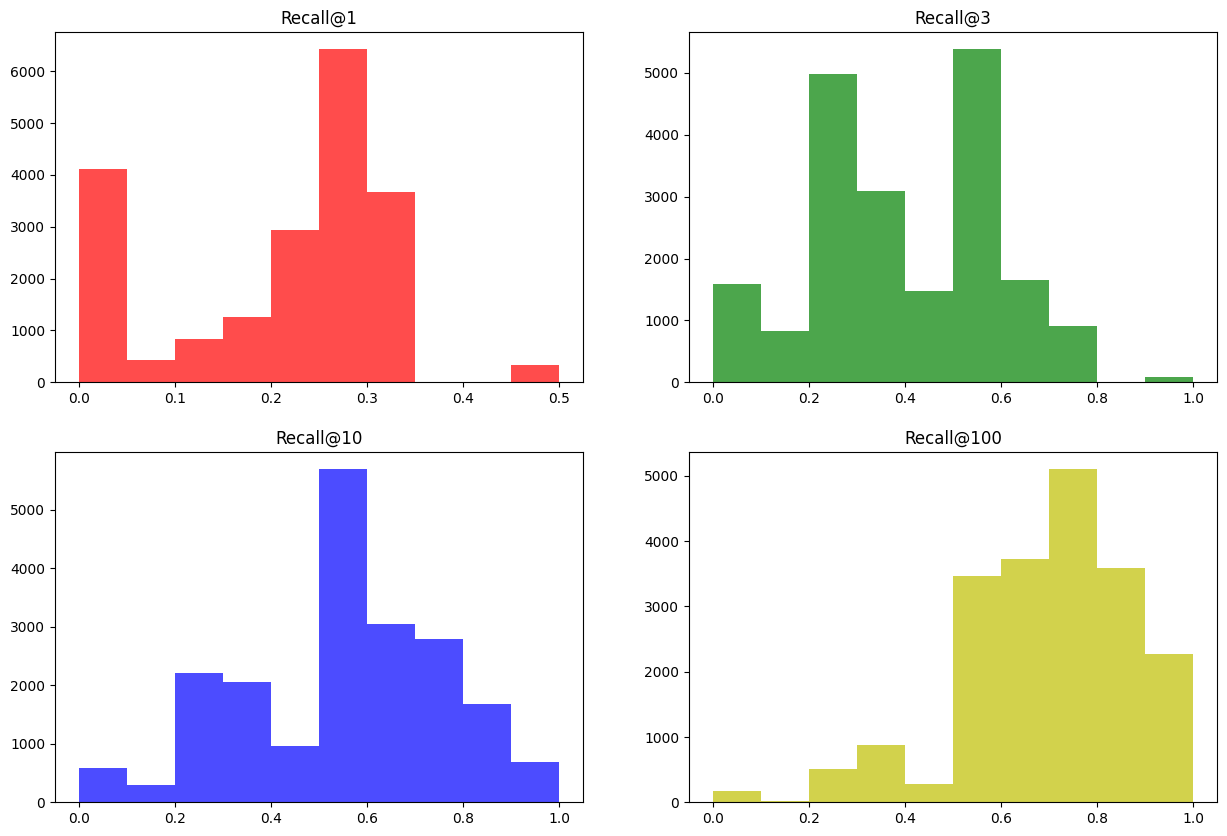

In [11]:
print_plot_results(df_ques_url_train)

Completed: 5000/5000: (100.00%)
Time taken: 1205.87 seconds
Recall@1: 0.2018
Recall@3: 0.3686
Recall@10: 0.5054
Recall@100: 0.6519

MRR@1: 0.7804
MRR@3: 0.8434
MRR@10: 0.8531
MRR@100: 0.8543


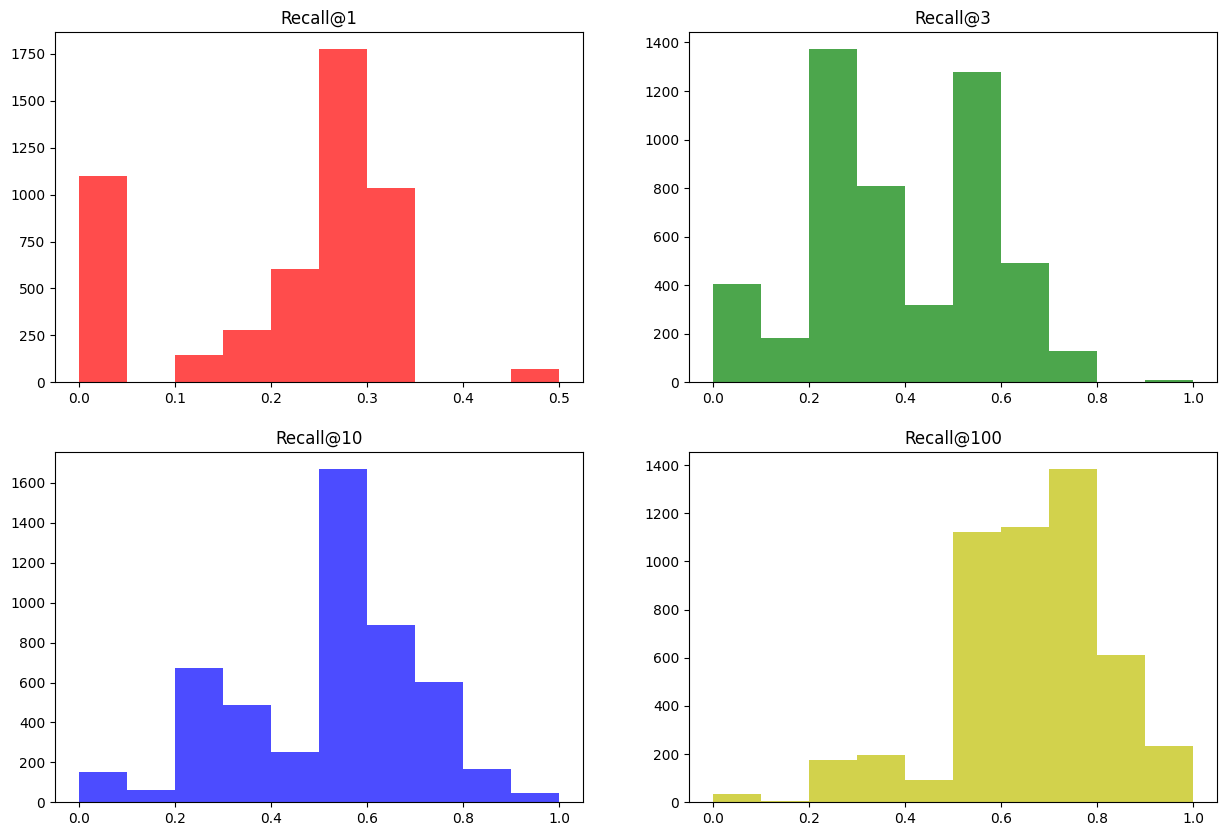

In [12]:
print_plot_results(df_ques_url_test)